In [235]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.functions import col,expr,to_date
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as sum_


In [236]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("Flights").getOrCreate()

In [237]:
spark

<h2>Data Preparation</h2>

<h3>Data Extract</h3>

In [238]:
df = spark.read.csv("Combined_Flights_2022.csv", header=True, inferSchema=True)

### Display data frame

In [239]:
df.show()

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|De

<h2>Drop unnecessary data</h2>

In [240]:
columns_to_drop = [
    "CRSDepTime", "DepTime", "DepDelayMinutes", "ArrDelayMinutes", "AirTime",
    "CRSElapsedTime", "ActualElapsedTime", "Year", "Month", "Operated_or_Branded_Code_Share_Partners",
    "DayofMonth", "DayOfWeek", "Marketing_Airline_Network", "DOT_ID_Marketing_Airline", "OriginCityMarketID",
    "IATA_Code_Marketing_Airline", "Tail_Number", "OriginAirportID", "OriginAirportSeqID", "OriginStateFips",
    "OriginWac", "DestAirportID", "DestAirportSeqID", "DestCityMarketID", "TaxiOut",
    "DestStateFips", "DestWac", "DepDel15", "DepartureDelayGroups", "WheelsOff",
    "WheelsOn", "TaxiIn", "ArrivalDelayGroups", "ArrDel15","ArrDelay","DivAirportLandings","CRSArrTime","DepDelay"
]
df = df.drop(*columns_to_drop)

In [241]:
df.show()

+----------+--------------------+------+----+---------+--------+-------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+---------------+-------------------+---------+-------------+----------+----------+-------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|ArrTime|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|      OriginCityName|OriginState|OriginStateName|       DestCityName|DestState|DestStateName|DepTimeBlk|ArrTimeBlk|DistanceGroup|
+----------+--------------------+------+----+---------+--------+-------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+---------------+-------------------

<h2>Transform data</h2>
<ul>
<li>convert ArrTime to date</li>
<li>convert DepTimeBlk to 2 columns DepTimeBlkStart and DepTimeBlkEnd</li>
<li>convert ArrTimeBlk to 2 columns ArrTimeBlkStart and ArrTimeBlkEnd</li>
</ul>

<h2>

<h3>Here we convert the Arrival Time formatted time strings</h3>

In [242]:
df = df.withColumn("ArrTimeStr", col("ArrTime").cast("int").cast("string")) \
                        .withColumn("ArrTimeFormatted", 
                                    expr("substring(ArrTimeStr, 1, length(ArrTimeStr) - 2) || ':' || substring(ArrTimeStr, -2)"))
df.show()

+----------+--------------------+------+----+---------+--------+-------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+---------------+-------------------+---------+-------------+----------+----------+-------------+----------+----------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|ArrTime|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|      OriginCityName|OriginState|OriginStateName|       DestCityName|DestState|DestStateName|DepTimeBlk|ArrTimeBlk|DistanceGroup|ArrTimeStr|ArrTimeFormatted|
+----------+--------------------+------+----+---------+--------+-------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+------------

<h3>Here we drop and update the column</h3>

In [243]:
df=df.drop("ArrTime","ArrTimeStr")
df=df.withColumnRenamed("ArrTimeFormatted", "ArrTime")

<h3>Here we split the Departure Time Block to 2 columns the Departure Time Block Start and End</h3>

In [244]:
df= df.withColumn("DepTimeBlkStart", expr("substring(DepTimeBlk, 1, 2) || ':00'")) \
                .withColumn("DepTimeBlkEnd", expr("substring(DepTimeBlk, 6, 2) || ':59'")) \
                .drop("DepTimeBlk")
df.show()

+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+---------------+-------------------+---------+-------------+----------+-------------+-------+---------------+-------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|      OriginCityName|OriginState|OriginStateName|       DestCityName|DestState|DestStateName|ArrTimeBlk|DistanceGroup|ArrTime|DepTimeBlkStart|DepTimeBlkEnd|
+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+-----

<h3>Here we split the Arrival Time Block to 2 columns the Arrival Time Block Start and End</h3>

In [245]:
df= df.withColumn("ArrTimeBlkStart", expr("substring(ArrTimeBlk, 1, 2) || ':00'")) \
                .withColumn("ArrTimeBlkEnd", expr("substring(ArrTimeBlk, 6, 2) || ':59'")) \
                .drop("ArrTimeBlk")
df.show()

+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+---------------+-------------------+---------+-------------+-------------+-------+---------------+-------------+---------------+-------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|      OriginCityName|OriginState|OriginStateName|       DestCityName|DestState|DestStateName|DistanceGroup|ArrTime|DepTimeBlkStart|DepTimeBlkEnd|ArrTimeBlkStart|ArrTimeBlkEnd|
+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+

<h3>Here we check for the data types that need to be changed</h3>

In [246]:
df.dtypes

[('FlightDate', 'date'),
 ('Airline', 'string'),
 ('Origin', 'string'),
 ('Dest', 'string'),
 ('Cancelled', 'boolean'),
 ('Diverted', 'boolean'),
 ('Distance', 'double'),
 ('Quarter', 'int'),
 ('Flight_Number_Marketing_Airline', 'int'),
 ('Operating_Airline', 'string'),
 ('DOT_ID_Operating_Airline', 'int'),
 ('IATA_Code_Operating_Airline', 'string'),
 ('Flight_Number_Operating_Airline', 'int'),
 ('OriginCityName', 'string'),
 ('OriginState', 'string'),
 ('OriginStateName', 'string'),
 ('DestCityName', 'string'),
 ('DestState', 'string'),
 ('DestStateName', 'string'),
 ('DistanceGroup', 'int'),
 ('ArrTime', 'string'),
 ('DepTimeBlkStart', 'string'),
 ('DepTimeBlkEnd', 'string'),
 ('ArrTimeBlkStart', 'string'),
 ('ArrTimeBlkEnd', 'string')]

In [247]:
df.show()

+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------------+-----------+---------------+-------------------+---------+-------------+-------------+-------+---------------+-------------+---------------+-------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|      OriginCityName|OriginState|OriginStateName|       DestCityName|DestState|DestStateName|DistanceGroup|ArrTime|DepTimeBlkStart|DepTimeBlkEnd|ArrTimeBlkStart|ArrTimeBlkEnd|
+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+

## How many the number of rows in the dataframe

In [248]:
df.count()

4078318

## Print the Schema 

In [249]:
df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- DOT_ID_Operating_Airline: integer (nullable = true)
 |-- IATA_Code_Operating_Airline: string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- DepTimeBlkStart: string (nulla

In [250]:
df.describe().show()

+-------+--------------------+-------+-------+-----------------+------------------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------+-----------+---------------+------------+---------+-------------+------------------+-------+---------------+-------------+---------------+-------------+
|summary|             Airline| Origin|   Dest|         Distance|           Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|OriginCityName|OriginState|OriginStateName|DestCityName|DestState|DestStateName|     DistanceGroup|ArrTime|DepTimeBlkStart|DepTimeBlkEnd|ArrTimeBlkStart|ArrTimeBlkEnd|
+-------+--------------------+-------+-------+-----------------+------------------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+----------

<h2>Load the data to Postgrsql</h2>

In [251]:
import psycopg2
from psycopg2 import OperationalError

# Function to create a connection to the PostgreSQL database
def create_connection(db_name, db_user, db_password, db_host, db_port):
    connection = None
    try:
        connection = psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port,
        )
        print("Connection to PostgreSQL DB successful")
    except OperationalError as e:
        print(f"The error '{e}' occurred")

    return connection

# Function to create the flights table
def create_table(connection):
    create_table_query = """
    CREATE TABLE IF NOT EXISTS flights (
        FlightDate DATE,
        Airline VARCHAR(255),
        Origin VARCHAR(255),
        Dest VARCHAR(255),
        Cancelled BOOLEAN,
        Diverted BOOLEAN,
        Distance REAL,
        Quarter INT,
        Flight_Number_Marketing_Airline INT,
        Operating_Airline VARCHAR(255),
        DOT_ID_Operating_Airline INT,
        IATA_Code_Operating_Airline VARCHAR(255),
        Flight_Number_Operating_Airline INT,
        OriginCityName VARCHAR(255),
        OriginState VARCHAR(255),
        OriginStateName VARCHAR(255),
        DestCityName VARCHAR(255),
        DestState VARCHAR(255),
        DestStateName VARCHAR(255),
        DistanceGroup INT,
        ArrTime VARCHAR(255),
        DepTimeBlkStart VARCHAR(255),
        DepTimeBlkEnd VARCHAR(255),
        ArrTimeBlkStart VARCHAR(255),
        ArrTimeBlkEnd VARCHAR(255)
    );
    """
    try:
        cursor = connection.cursor()
        cursor.execute(create_table_query)
        connection.commit()
        print("Table 'flights' created successfully")
    except OperationalError as e:
        print(f"The error '{e}' occurred")

# Database connection parameters
db_name = "postgres"
db_user = "postgres"
db_password = "root"
db_host = "localhost"  # Usually localhost if it's on your local machine
db_port = "5432"  # Usually 5432 for PostgreSQL

# Create a connection to the PostgreSQL database
connection = create_connection(db_name, db_user, db_password, db_host, db_port)

# Create the flights table
create_table(connection)

# Close the connection
if connection:
    connection.close()


Connection to PostgreSQL DB successful
Table 'flights' created successfully


## Clean & Visualization

In [252]:
from pyspark.sql.functions import col, sum as sum_

# Count of missing values per column
missing_values = df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+----------+-------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------+-----------+---------------+------------+---------+-------------+-------------+-------+---------------+-------------+---------------+-------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|OriginCityName|OriginState|OriginStateName|DestCityName|DestState|DestStateName|DistanceGroup|ArrTime|DepTimeBlkStart|DepTimeBlkEnd|ArrTimeBlkStart|ArrTimeBlkEnd|
+----------+-------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------+-----------+---------------+------------+---------

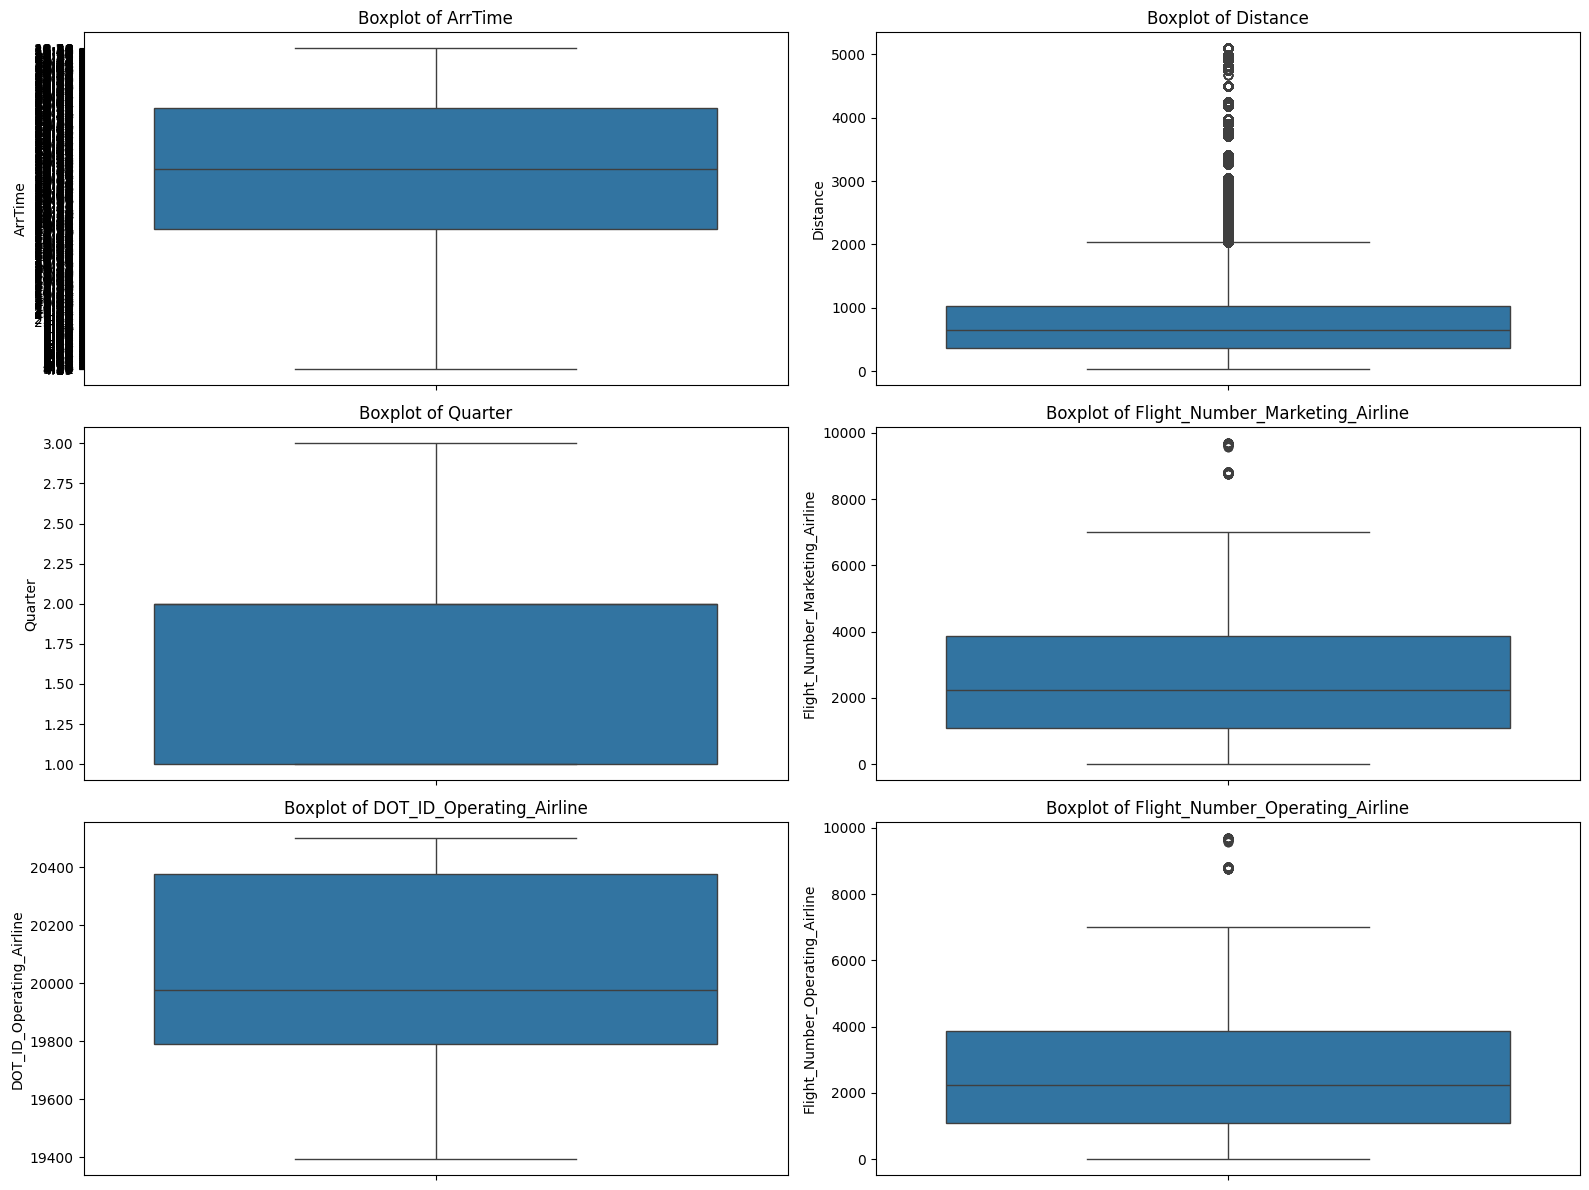

In [253]:
numerical_columns = ['ArrTime', 'Distance', 'Quarter', 'Flight_Number_Marketing_Airline', 'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline']

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df.select(numerical_columns).toPandas()

# Plotting boxplots for each numerical column
plt.figure(figsize=(16, 12))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)  # Adjust the layout based on the number of columns
    sns.boxplot(y=df_pd[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [254]:
columns_to_check = ['ArrTime', 'Distance', 'Quarter', 'Flight_Number_Marketing_Airline', 'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline']

# Cast ArrTime to double if it's stored as string
from pyspark.sql.types import DoubleType

df = df.withColumn("ArrTime", col("ArrTime").cast(DoubleType()))


# Function to identify outliers using IQR
def identify_outliers(df, column):
    # Calculate Q1 and Q3
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_df = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return outliers_df

# Identify and display outliers for each numerical column
for column in columns_to_check:
    try:
        outliers_df = identify_outliers(df, column)
        outlier_count = outliers_df.count()
        print(f"Outliers in {column}: {outlier_count}")
        outliers_df.show()
    except Exception as e:
        print(f"Could not calculate outliers for column {column}: {e}")

Could not calculate outliers for column ArrTime: list index out of range
Outliers in Distance: 234125
+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+--------------+-----------+---------------+---------------+---------+-------------+-------------+-------+---------------+-------------+---------------+-------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|Distance|Quarter|Flight_Number_Marketing_Airline|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Flight_Number_Operating_Airline|OriginCityName|OriginState|OriginStateName|   DestCityName|DestState|DestStateName|DistanceGroup|ArrTime|DepTimeBlkStart|DepTimeBlkEnd|ArrTimeBlkStart|ArrTimeBlkEnd|
+----------+--------------------+------+----+---------+--------+--------+-------+-------------------------------+-----------------+---

In [255]:
categorical_columns = [c for c, t in df.dtypes if t == 'string']
for column in categorical_columns:
    df.groupBy(column).count().show()


+--------------------+------+
|             Airline| count|
+--------------------+------+
|GoJet Airlines, L...| 34793|
|   Endeavor Air Inc.|142624|
|SkyWest Airlines ...|440807|
|Air Wisconsin Air...| 40300|
|Southwest Airline...|731925|
|Commutair Aka Cha...| 44367|
|Capital Cargo Int...| 52827|
|Alaska Airlines Inc.|129510|
|  Mesa Airlines Inc.| 71972|
|American Airlines...|495953|
|   Republic Airlines|197881|
|       Allegiant Air| 73504|
|         Horizon Air| 56320|
|         Comair Inc.|135884|
|Frontier Airlines...| 86557|
|     JetBlue Airways|156793|
|           Envoy Air|150758|
|Hawaiian Airlines...| 42212|
|Delta Air Lines Inc.|512114|
|    Spirit Air Lines|129208|
+--------------------+------+
only showing top 20 rows

+------+-----+
|Origin|count|
+------+-----+
|   BGM|  212|
|   MSY|27654|
|   GEG|11336|
|   BUR|18021|
|   SNA|26795|
|   GRB| 2697|
|   IDA| 2741|
|   GRR|10100|
|   EUG| 5331|
|   PSG|  420|
|   PVD| 9518|
|   GSO| 7354|
|   MYR| 9757|
|   OAK|26610|

In [256]:
# Group by a categorical column and compute the mean of numeric columns
grouped_df = df.groupBy('Origin').mean()
grouped_df.show()

# Group by and aggregate multiple statistics
from pyspark.sql.functions import avg, max, min

df.groupBy('Origin').agg(
    avg('Distance').alias('average'),
    max('ArrTime').alias('max'),
    min('Quarter').alias('min')
).show()


+------+------------------+------------------+------------------------------------+-----------------------------+------------------------------------+------------------+------------+
|Origin|     avg(Distance)|      avg(Quarter)|avg(Flight_Number_Marketing_Airline)|avg(DOT_ID_Operating_Airline)|avg(Flight_Number_Operating_Airline)|avg(DistanceGroup)|avg(ArrTime)|
+------+------------------+------------------+------------------------------------+-----------------------------+------------------------------------+------------------+------------+
|   BGM|             378.0| 1.721698113207547|                              5425.0|                      20363.0|                              5425.0|               2.0|        NULL|
|   MSY| 763.0241194763868|1.7307441961379908|                  1924.1411730671873|           19828.329464091992|                  1924.1411730671873|3.4805091487669055|        NULL|
|   GEG|  583.936044460127|1.7829040225829216|                   2184.361326746648|  

<h2>1-What is Frequency of flights by each airline?</h2>

In [257]:
Frequency_of_flights=df.groupBy('Airline').count().orderBy('count', ascending=False)
Frequency_of_flights.show()

+--------------------+------+
|             Airline| count|
+--------------------+------+
|Southwest Airline...|731925|
|Delta Air Lines Inc.|512114|
|American Airlines...|495953|
|SkyWest Airlines ...|440807|
|United Air Lines ...|352009|
|   Republic Airlines|197881|
|     JetBlue Airways|156793|
|           Envoy Air|150758|
|   Endeavor Air Inc.|142624|
|         Comair Inc.|135884|
|Alaska Airlines Inc.|129510|
|    Spirit Air Lines|129208|
|Frontier Airlines...| 86557|
|       Allegiant Air| 73504|
|  Mesa Airlines Inc.| 71972|
|         Horizon Air| 56320|
|Capital Cargo Int...| 52827|
|Commutair Aka Cha...| 44367|
|Hawaiian Airlines...| 42212|
|Air Wisconsin Air...| 40300|
+--------------------+------+
only showing top 20 rows



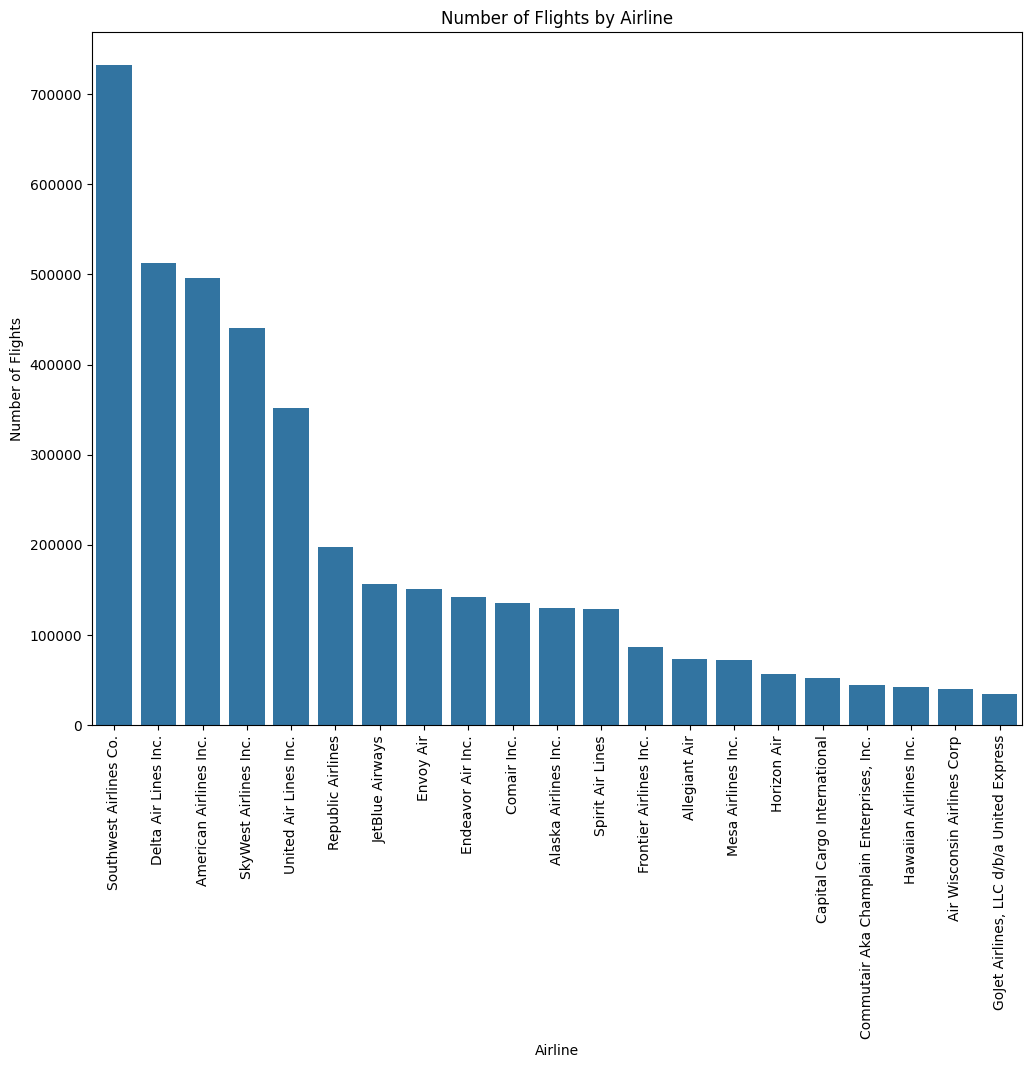

In [258]:
# Visualize
airline_count_pd = Frequency_of_flights.toPandas()
plt.figure(figsize=(12, 9))
sns.barplot(x='Airline', y='count', data=airline_count_pd)
plt.title('Number of Flights by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.show()

<h2>2-What is Top 10 busiest destination airports?</h2>

In [259]:
df.groupBy('Origin').count().orderBy('count', ascending=False).show(10)


+------+------+
|Origin| count|
+------+------+
|   ATL|183697|
|   ORD|172169|
|   DFW|161218|
|   DEN|158092|
|   CLT|126088|
|   LAX|111935|
|   LGA|100260|
|   SEA| 98884|
|   LAS| 97674|
|   PHX| 96095|
+------+------+
only showing top 10 rows



C:\Users\moham\AppData\Local\Temp\ipykernel_17784\1874193984.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dest', y='count', data=dest_count_pd, palette=colors)


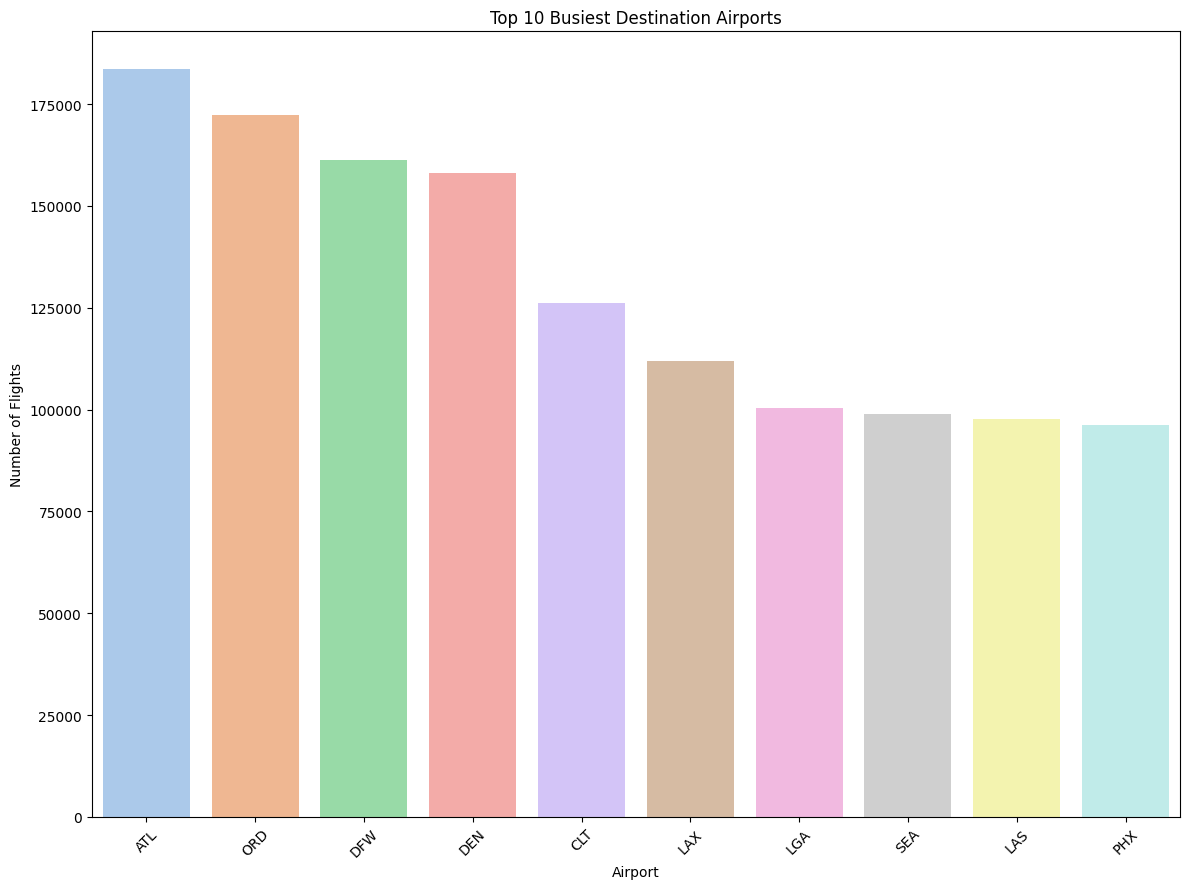

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette
colors = sns.color_palette('pastel')

# Filter the DataFrame to include only the top 10 busiest destination airports
Top_Busiest_Destination = df.groupBy('Dest').count().orderBy('count', ascending=False).limit(10)

# Visualize with colors assigned to each bar
dest_count_pd = Top_Busiest_Destination.toPandas()
plt.figure(figsize=(12, 9))
sns.barplot(x='Dest', y='count', data=dest_count_pd, palette=colors)
plt.title('Top 10 Busiest Destination Airports')  # Heading indicating the limitation
plt.xlabel('Airport')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better visualization
plt.show()


<h2>3-What is Cancellation rate?</h2>

In [261]:
Cancellation=df.groupBy('Cancelled').count().withColumn('percentage', col('count') / df.count() * 100)
Cancellation.show()


+---------+-------+-----------------+
|Cancelled|  count|       percentage|
+---------+-------+-----------------+
|     true| 123192|3.020657045379983|
|    false|3955126|96.97934295462002|
+---------+-------+-----------------+



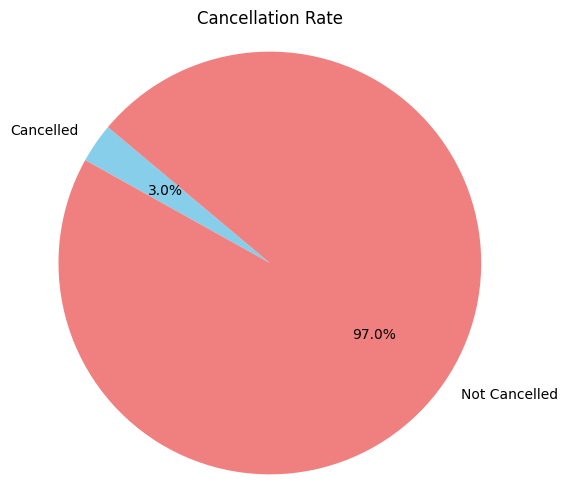

In [262]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Convert to Pandas DataFrame for plotting
Cancellation_pd = Cancellation.toPandas()

# Map boolean values to labels
label_map = {0: 'Not Cancelled', 1: 'Cancelled'}
labels = [label_map[c] for c in Cancellation_pd['Cancelled']]

# Visualize cancellation rate
plt.figure(figsize=(6, 6))
plt.pie(Cancellation_pd['count'], labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Cancellation Rate')
plt.axis('equal')
plt.show()

label_map = {False: 'Not Cancelled', True: 'Cancelled'}


<h2>4-What is Number of flights per quarter?</2>

+-------+-------+
|Quarter|  count|
+-------+-------+
|      1|1674231|
|      2|1785297|
|      3| 618790|
+-------+-------+



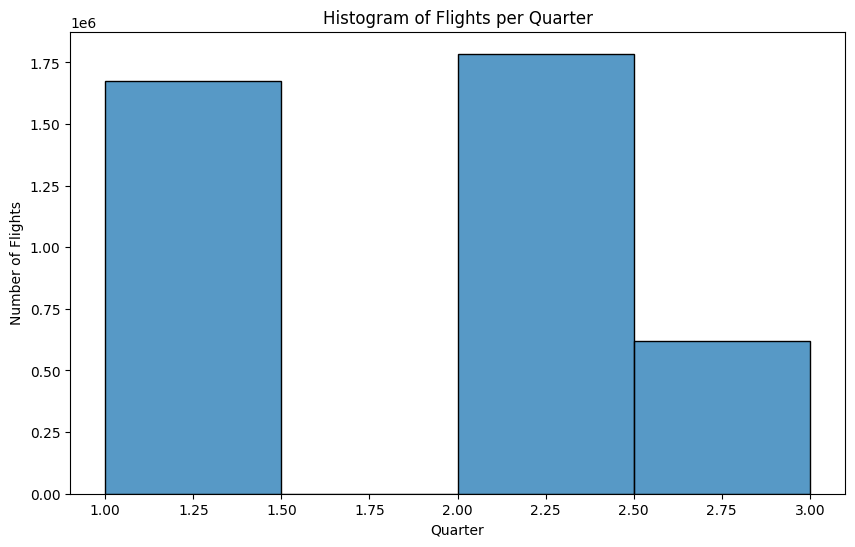

+-------+-------+
|Quarter|  count|
+-------+-------+
|      1|1674231|
|      2|1785297|
|      3| 618790|
+-------+-------+



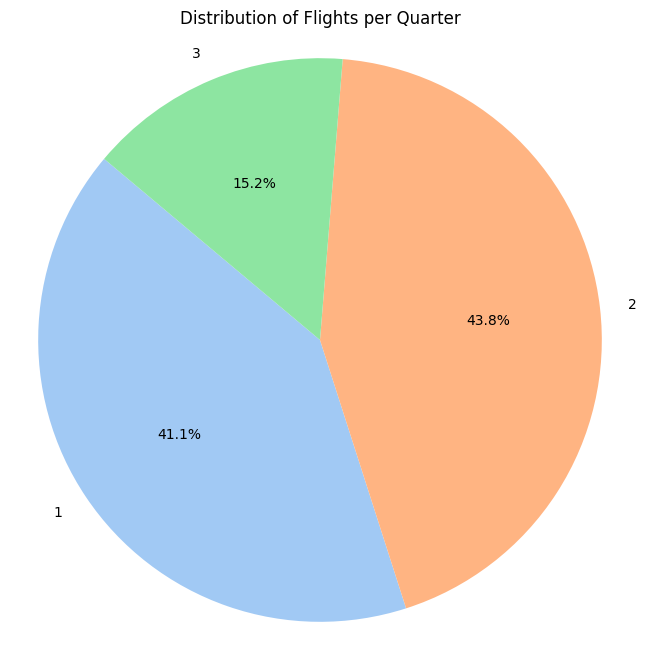

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of flights per quarter
quarter_count = df.groupBy('Quarter').count().orderBy('Quarter')
quarter_count.show()

# Convert to Pandas DataFrame
quarter_count_pd = quarter_count.toPandas()

# Visualize with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(quarter_count_pd, x='Quarter', weights='count', bins=4, kde=False)
plt.title('Histogram of Flights per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Flights')
plt.show()

# Number of flights per quarter
quarter_count = df.groupBy('Quarter').count().orderBy('Quarter')
quarter_count.show()

# Convert to Pandas DataFrame
quarter_count_pd = quarter_count.toPandas()

# Visualize with a pie chart
plt.figure(figsize=(8, 8))
plt.pie(quarter_count_pd['count'], labels=quarter_count_pd['Quarter'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Flights per Quarter')
plt.axis('equal')
plt.show()


## 5-What is Frequency of flight numbers by marketing airline?

+-------------------------------+-----+
|Flight_Number_Marketing_Airline|count|
+-------------------------------+-----+
|                            772| 1842|
|                            418| 1828|
|                            770| 1806|
|                            573| 1791|
|                             61| 1687|
|                            679| 1644|
|                           2142| 1642|
|                            698| 1634|
|                           2127| 1627|
|                            340| 1621|
+-------------------------------+-----+



C:\Users\moham\AppData\Local\Temp\ipykernel_17784\1125716134.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Flight_Number_Marketing_Airline', data=flight_num_count_pd, palette='coolwarm')


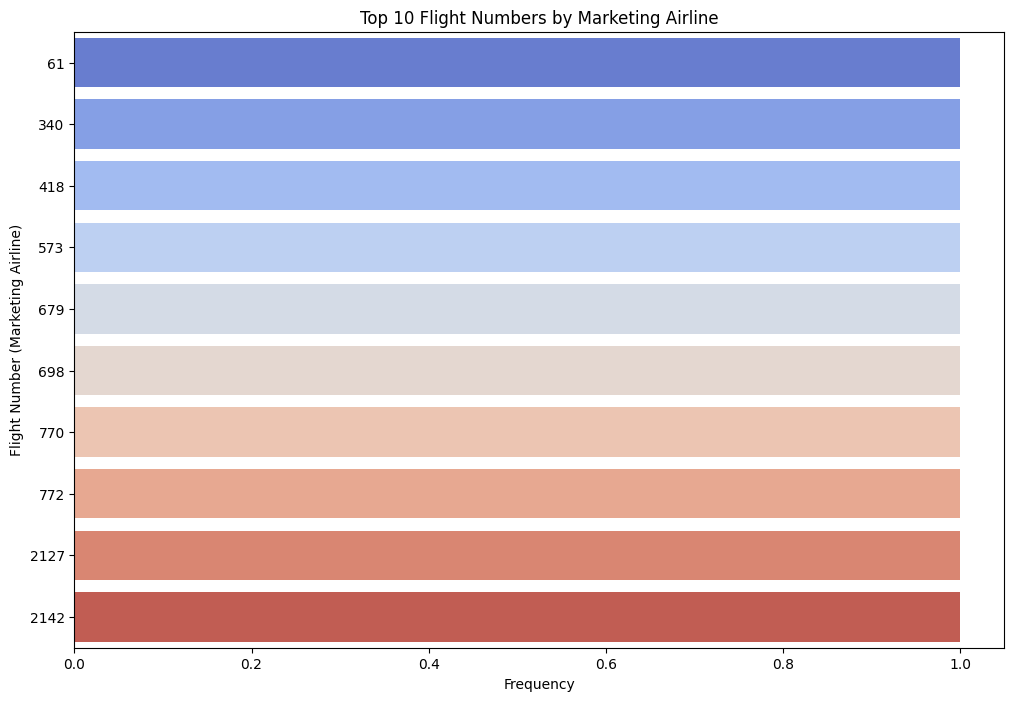

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the frequency of flight numbers by marketing airline
flight_num_count = df.groupBy('Flight_Number_Marketing_Airline').count().orderBy('count', ascending=False).limit(10)
flight_num_count.show()

# Convert to Pandas DataFrame for plotting
flight_num_count_pd = flight_num_count.toPandas()

# Visualize with a count plot
plt.figure(figsize=(12, 8))
sns.countplot(y='Flight_Number_Marketing_Airline', data=flight_num_count_pd, palette='coolwarm')
plt.title('Top 10 Flight Numbers by Marketing Airline')
plt.xlabel('Frequency')
plt.ylabel('Flight Number (Marketing Airline)')
plt.show()


## 6-What is the average distance for each route?


+------+----+----------------+
|Origin|Dest|Average_Distance|
+------+----+----------------+
|   SPI| ORD|           174.0|
|   ATL| GSP|           153.0|
|   DAL| LGB|          1232.0|
|   MDW| MEM|           480.0|
|   PHL| MCO|           861.0|
|   SJC| LIH|          2466.0|
|   SMF| BUR|           358.0|
|   SNA| PHX|           338.0|
|   LAS| LIT|          1294.0|
|   MCI| IAH|           643.0|
|   STS| PHX|           699.0|
|   PBI| DCA|           857.0|
|   ORD| PDX|          1739.0|
|   CPR| DEN|           230.0|
|   ICT| IAH|           542.0|
|   ABQ| BUR|           672.0|
|   AUS| ELP|           528.0|
|   SJC| ONT|           333.0|
|   TPA| CVG|           773.0|
|   JFK| ORD|           740.0|
+------+----+----------------+
only showing top 20 rows



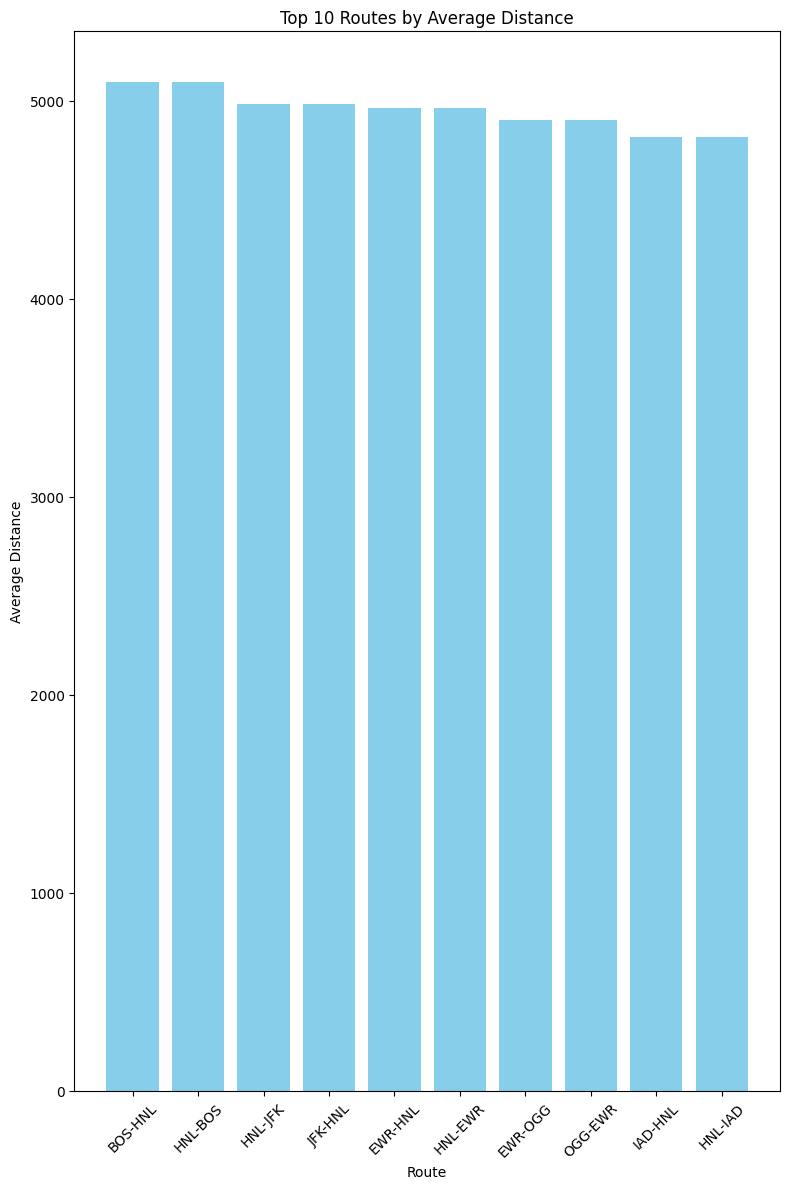

In [265]:
average_distance = df.groupBy("Origin", "Dest").agg(avg("Distance").alias("Average_Distance"))
average_distance.show()
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already computed the average distance
# Convert PySpark DataFrame to Pandas DataFrame
average_distance_pd = average_distance.toPandas()

# Sort the DataFrame by Average_Distance in descending order and select the top 10 routes
top_routes = average_distance_pd.sort_values(by='Average_Distance', ascending=False).head(10)

# Plotting with Matplotlib
plt.figure(figsize=(8, 12))  # Adjust the figure size to make it vertical
plt.bar(range(len(top_routes)), top_routes['Average_Distance'], color='skyblue')  # Use plt.bar instead of plt.barh
plt.ylabel('Average Distance')  # Switch x-axis and y-axis labels
plt.xlabel('Route')
plt.title('Top 10 Routes by Average Distance')
plt.xticks(range(len(top_routes)), [f"{origin}-{dest}" for origin, dest in zip(top_routes['Origin'], top_routes['Dest'])], rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()




## 7-How does performance vary during different departure blocks?

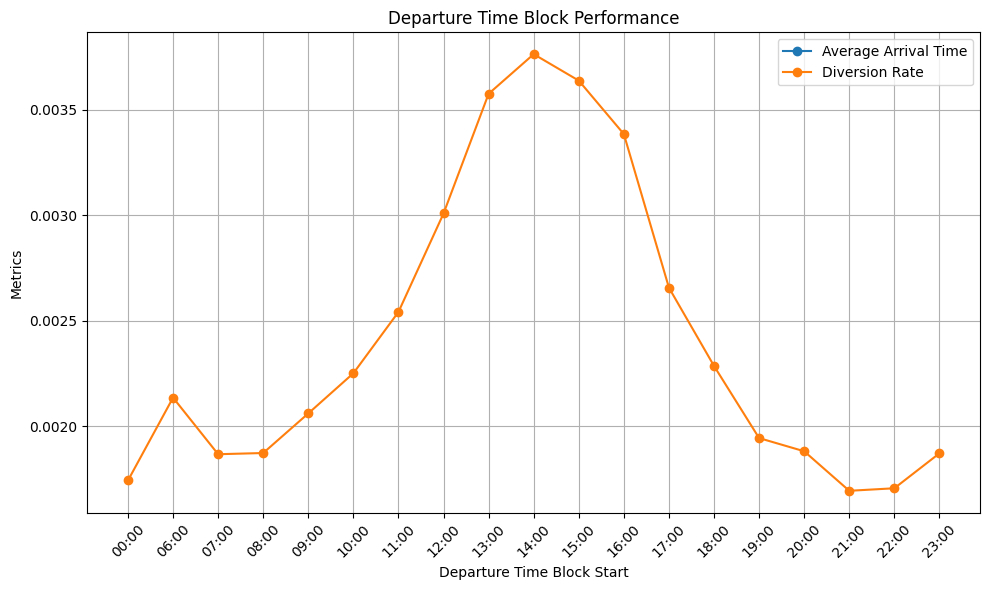

In [266]:
from pyspark.sql.functions import avg, count, col, sum
import matplotlib.pyplot as plt
# Convert ArrTime to numeric value for average calculation (assuming it represents time in minutes or similar)
df = df.withColumn("ArrTime", col("ArrTime").cast("double"))

# Calculate performance metrics by departure time block
departure_block_performance = df.groupBy("DepTimeBlkStart").agg(
    avg("ArrTime").alias("Average_Arrival_Time"),
    (sum(col("Diverted").cast("int")) / count("*")).alias("Diversion_Rate")
)

# Convert PySpark DataFrame to Pandas DataFrame
departure_block_performance_pd = departure_block_performance.toPandas()

# Sort the Pandas DataFrame by DepTimeBlkStart to ensure proper ordering
departure_block_performance_pd = departure_block_performance_pd.sort_values(by="DepTimeBlkStart")

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

# Plot Average Arrival Time
plt.plot(departure_block_performance_pd["DepTimeBlkStart"], departure_block_performance_pd["Average_Arrival_Time"], marker='o', label='Average Arrival Time')

# Plot Diversion Rate
plt.plot(departure_block_performance_pd["DepTimeBlkStart"], departure_block_performance_pd["Diversion_Rate"], marker='o', label='Diversion Rate')

plt.xlabel('Departure Time Block Start')
plt.ylabel('Metrics')
plt.title('Departure Time Block Performance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h2>Paralize & RDD</h2>

In [267]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, DoubleType, IntegerType

# Create a SparkSession
spark = SparkSession.builder \
    .appName("FlightData") \
    .master("local[*]") \
    .getOrCreate()

# Define schema for the DataFrame
schema = StructType([
    StructField("FlightDate", StringType(), True),
    StructField("Airline", StringType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Cancelled", BooleanType(), True),
    StructField("Diverted", BooleanType(), True),
    StructField("Distance", DoubleType(), True),
    StructField("Quarter", IntegerType(), True),
    StructField("Flight_Number_Marketing_Airline", IntegerType(), True),
    StructField("Operating_Airline", StringType(), True),
    StructField("DOT_ID_Operating_Airline", IntegerType(), True),
    StructField("IATA_Code_Operating_Airline", StringType(), True),
    StructField("Flight_Number_Operating_Airline", IntegerType(), True),
    StructField("OriginCityName", StringType(), True),
    StructField("OriginState", StringType(), True),
    StructField("OriginStateName", StringType(), True),
    StructField("DestCityName", StringType(), True),
    StructField("DestState", StringType(), True),
    StructField("DestStateName", StringType(), True),
    StructField("DistanceGroup", IntegerType(), True),
    StructField("ArrTime", StringType(), True),
    StructField("DepTimeBlkStart", StringType(), True),
    StructField("DepTimeBlkEnd", StringType(), True),
    StructField("ArrTimeBlkStart", StringType(), True),
    StructField("ArrTimeBlkEnd", StringType(), True)
])

# Create a list of tuples representing your data
data = [
    ('2024-01-01', 'AA', 'JFK', 'LAX', False, False, 2475.0, 1, 101, 'American Airlines', 19805, 'AA', 101, 'New York City', 'NY', 'New York', 'Los Angeles', 'CA', 'California', 5, '08:47', '0600-0659', '0800-0859', '1100-1159', '1200-1259'),
    ('2024-01-02', 'DL', 'ATL', 'ORD', False, False, 606.0, 1, 103, 'Delta Air Lines', 19790, 'DL', 103, 'Atlanta', 'GA', 'Georgia', 'Chicago', 'IL', 'Illinois', 2, '10:03', '1000-1059', '1000-1059', '1100-1159', '1100-1159')
    # Add more data tuples here if needed
]

# Parallelize the data and create an RDD
rdd = spark.sparkContext.parallelize(data)

# Create DataFrame from RDD and schema
df = spark.createDataFrame(rdd, schema)

# Show schema
df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- DOT_ID_Operating_Airline: integer (nullable = true)
 |-- IATA_Code_Operating_Airline: string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- DepTimeBlkStart: string (nul

## Scale&Normlization

C:\Users\moham\AppData\Local\Temp\ipykernel_17784\1195298827.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_df, ax=ax[0],color='skyblue')
C:\Users\moham\AppData\Local\Temp\ipykernel_17784\1195298827.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scaled_df, ax=ax[1],color='sk

Text(0.5, 1.0, 'Scaled out_df')

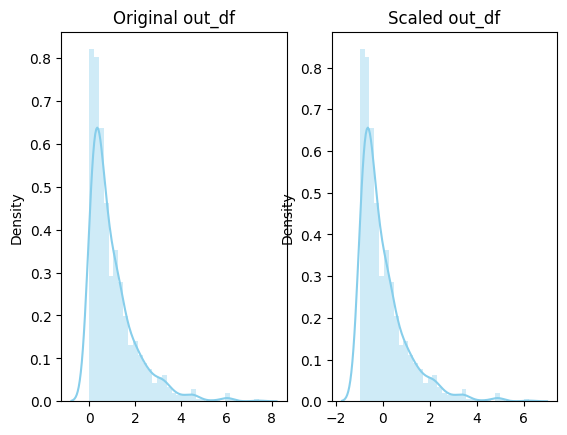

In [268]:
import numpy as np
import  matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# generate 1000 out_df points randomly drawn from an exponential distribution
original_df = np.random.exponential(size=1000).reshape(-1, 1)

scaler = StandardScaler()
# scale the out_df using z-score scaling
scaled_df = scaler.fit_transform(original_df)


fig, ax=plt.subplots(1,2)
sns.distplot(original_df, ax=ax[0],color='skyblue')
ax[0].set_title("Original out_df")
sns.distplot(scaled_df, ax=ax[1],color='skyblue')
ax[1].set_title("Scaled out_df")

In [273]:
df.dtypes

[('FlightDate', 'string'),
 ('Airline', 'string'),
 ('Origin', 'string'),
 ('Dest', 'string'),
 ('Cancelled', 'boolean'),
 ('Diverted', 'boolean'),
 ('Distance', 'double'),
 ('Quarter', 'int'),
 ('Flight_Number_Marketing_Airline', 'int'),
 ('Operating_Airline', 'string'),
 ('DOT_ID_Operating_Airline', 'int'),
 ('IATA_Code_Operating_Airline', 'string'),
 ('Flight_Number_Operating_Airline', 'int'),
 ('OriginCityName', 'string'),
 ('OriginState', 'string'),
 ('OriginStateName', 'string'),
 ('DestCityName', 'string'),
 ('DestState', 'string'),
 ('DestStateName', 'string'),
 ('DistanceGroup', 'int'),
 ('ArrTime', 'string'),
 ('DepTimeBlkStart', 'string'),
 ('DepTimeBlkEnd', 'string'),
 ('ArrTimeBlkStart', 'string'),
 ('ArrTimeBlkEnd', 'string')]

In [275]:
for column in df.columns:
    df = df.withColumn(column, col(column).cast(IntegerType()))

In [283]:
df.dtypes

[('Distance', 'int'),
 ('Quarter', 'int'),
 ('ArrTime', 'int'),
 ('DepTime', 'int'),
 ('DepDelayMinutes', 'int'),
 ('ArrDelayMinutes', 'int'),
 ('AirTime', 'int'),
 ('CRSElapsedTime', 'int'),
 ('ActualElapsedTime', 'int'),
 ('DepDel15', 'int'),
 ('DepartureDelayGroups', 'int'),
 ('DepTimeBlk', 'int'),
 ('ArrTimeBlk', 'int'),
 ('DistanceGroup', 'int')]